# Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
import random

# Задание seed для воспроизводимости
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(52) # 52 bratuha


# Подготовка данных
train_df = pd.read_csv("loan_train.csv")
test_df = pd.read_csv("loan_test.csv")

train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)

target_col = "loan_status"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()
num_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()

# Label Encoding для категориальных признаков
encoders = {col: LabelEncoder().fit(pd.concat([X_train[col], X_test[col]], axis=0)) for col in cat_features}
for col in cat_features:
    X_train[col] = encoders[col].transform(X_train[col])
    X_test[col] = encoders[col].transform(X_test[col])

In [3]:
# проверка данных
# X_train

In [4]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# X_train

# Trainer

In [5]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

class Trainer:
    def __init__(self, model, train_loader, test_loader,
                 learning_rate=0.01, weight_decay=0.0,
                 epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = SGD(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.train_losses = []
        self.test_losses = []
        self.train_aucs = []
        self.test_aucs = []

    def train(self):
        for epoch in range(1, self.epochs + 1):
            train_loss, train_auc = self._train_one_epoch()
            test_loss, test_auc = self._evaluate()

            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.train_aucs.append(train_auc)
            self.test_aucs.append(test_auc)

            print(f"Epoch {epoch}/{self.epochs} | "
                  f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | "
                  f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")

    def _train_one_epoch(self):
        self.model.train()
        epoch_loss = 0
        preds, targets = [], []

        for xb, yb in self.train_loader:
            xb, yb = xb.to(self.device), yb.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(xb).squeeze(1)
            loss = self.criterion(logits, yb)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item() * xb.size(0)

            preds.extend(torch.sigmoid(logits).detach().cpu().numpy())
            targets.extend(yb.detach().cpu().numpy())

        epoch_loss /= len(self.train_loader.dataset)
        auc = roc_auc_score(targets, preds)
        return epoch_loss, auc

    def _evaluate(self):
        self.model.eval()
        epoch_loss = 0
        preds, targets = [], []

        with torch.no_grad():
            for xb, yb in self.test_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)

                logits = self.model(xb).squeeze(1)
                loss = self.criterion(logits, yb)

                epoch_loss += loss.item() * xb.size(0)
                preds.extend(torch.sigmoid(logits).cpu().numpy())
                targets.extend(yb.cpu().numpy())

        epoch_loss /= len(self.test_loader.dataset)
        auc = roc_auc_score(targets, preds)
        return epoch_loss, auc

    def plot_metrics(self, filename_prefix=None):
        epochs_range = range(1, self.epochs + 1)

        plt.figure(figsize=(14, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_losses, label="Train Loss")
        plt.plot(epochs_range, self.test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()

        # AUC plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.train_aucs, label="Train AUC")
        plt.plot(epochs_range, self.test_aucs, label="Test AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.title("ROC-AUC over Epochs")
        plt.legend()

        plt.tight_layout()

        if filename_prefix:
            loss_path = f"{filename_prefix}_loss.png"
            auc_path = f"{filename_prefix}_auc.png"
            plt.savefig(f"{filename_prefix}_combined.png")
            print(f"Графики сохранены как '{filename_prefix}_combined.png'")

        plt.show()

# Эксперименты

In [31]:
def plot_all_experiments(experiments, mode='both', filename=None):
    plt.figure(figsize=(14, 5))

    # --- AUC ---
    plt.subplot(1, 2, 1)
    for exp in experiments:
        label = exp.get('label', 'unnamed')
        if mode in ['train', 'both']:
            plt.plot(exp['train_aucs'], label=f"{label} - Train AUC")
        if mode in ['test', 'both']:
            plt.plot(exp['test_aucs'], label=f"{label} - Test AUC")
    plt.title("AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")
    plt.legend()

    # --- Loss ---
    plt.subplot(1, 2, 2)
    for exp in experiments:
        label = exp.get('label', 'unnamed')
        if mode in ['train', 'both']:
            plt.plot(exp['train_losses'], label=f"{label} - Train Loss")
        if mode in ['test', 'both']:
            plt.plot(exp['test_losses'], label=f"{label} - Test Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        print(f"✅ График сохранён как {filename}.png")

    plt.show()


In [16]:
def save_experiment_to_csv(experiment_dict, filename='experiment.csv'):
    df = pd.DataFrame({
        'epoch': list(range(1, len(experiment_dict['train_losses']) + 1)),
        'train_loss': experiment_dict['train_losses'],
        'test_loss': experiment_dict['test_losses'],
        'train_auc': experiment_dict['train_aucs'],
        'test_auc': experiment_dict['test_aucs']
    })

    df.to_csv(filename, index=False)
    print(f"Эксперимент сохранён в {filename}")

## Эксперимент 1

In [17]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_size=32):
        super(SimpleMLP, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.block(x)
        x = self.output_layer(x)
        return x

Epoch 1/60 | Train Loss: 0.3240, AUC: 0.8126 | Test Loss: 0.2638, AUC: 0.8886
Epoch 2/60 | Train Loss: 0.2659, AUC: 0.8826 | Test Loss: 0.2474, AUC: 0.8989
Epoch 3/60 | Train Loss: 0.2516, AUC: 0.8943 | Test Loss: 0.2367, AUC: 0.9065
Epoch 4/60 | Train Loss: 0.2433, AUC: 0.8994 | Test Loss: 0.2297, AUC: 0.9100
Epoch 5/60 | Train Loss: 0.2398, AUC: 0.9013 | Test Loss: 0.2296, AUC: 0.9093
Epoch 6/60 | Train Loss: 0.2370, AUC: 0.9026 | Test Loss: 0.2249, AUC: 0.9131
Epoch 7/60 | Train Loss: 0.2345, AUC: 0.9041 | Test Loss: 0.2220, AUC: 0.9140
Epoch 8/60 | Train Loss: 0.2321, AUC: 0.9053 | Test Loss: 0.2272, AUC: 0.9138
Epoch 9/60 | Train Loss: 0.2298, AUC: 0.9064 | Test Loss: 0.2187, AUC: 0.9152
Epoch 10/60 | Train Loss: 0.2274, AUC: 0.9079 | Test Loss: 0.2163, AUC: 0.9154
Epoch 11/60 | Train Loss: 0.2255, AUC: 0.9087 | Test Loss: 0.2126, AUC: 0.9172
Epoch 12/60 | Train Loss: 0.2229, AUC: 0.9099 | Test Loss: 0.2123, AUC: 0.9182
Epoch 13/60 | Train Loss: 0.2203, AUC: 0.9113 | Test Loss: 0.

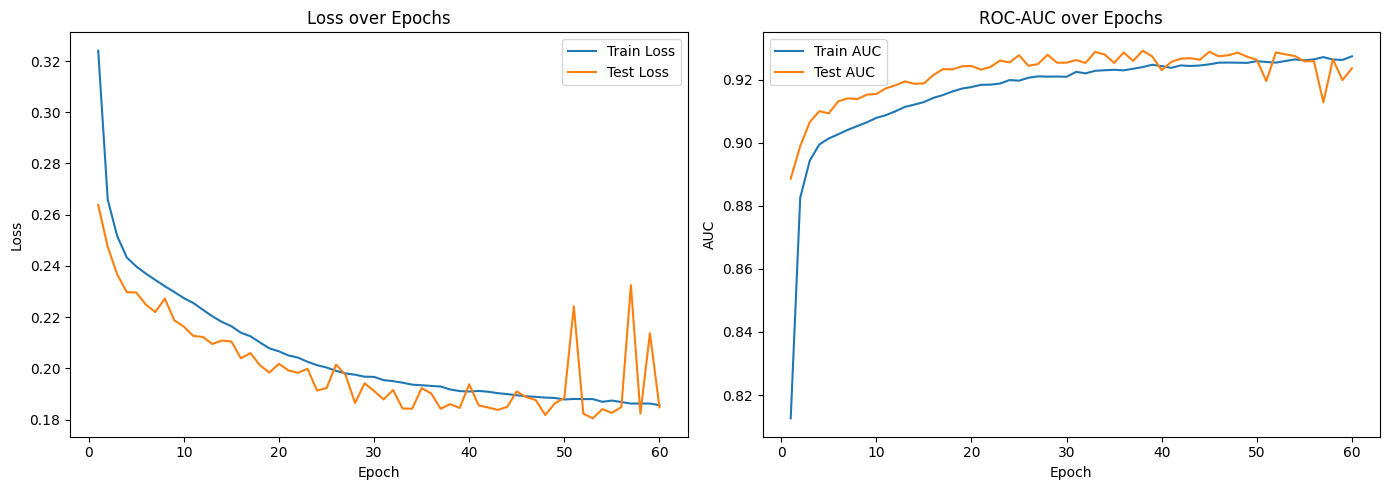

In [33]:
model = SimpleMLP(input_dim=X_train_tensor.shape[1], hidden_size=32)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    epochs=60
)

trainer.train()
trainer.plot_metrics('experiment_1')

In [34]:
experiment_1 = {
    'test_aucs': trainer.test_aucs,
    'train_aucs': trainer.train_aucs,
    'test_losses': trainer.test_losses,
    'train_losses': trainer.train_losses,
    'label': "exp1"
    }
save_experiment_to_csv(experiment_1, 'experiment_1.csv')
experiment_1

Эксперимент сохранён в experiment_1.csv


{'test_aucs': [np.float64(0.888588231092487),
  np.float64(0.8988787038249544),
  np.float64(0.9064968274187212),
  np.float64(0.9099586909679647),
  np.float64(0.9092860799276199),
  np.float64(0.9131153200557136),
  np.float64(0.9140150712491517),
  np.float64(0.9138184069237271),
  np.float64(0.9151883906143976),
  np.float64(0.9154191021535457),
  np.float64(0.9171924143760193),
  np.float64(0.9181797835740053),
  np.float64(0.9194102451161297),
  np.float64(0.9186362067118247),
  np.float64(0.9187612052237474),
  np.float64(0.9214168878941917),
  np.float64(0.9232954369590839),
  np.float64(0.9232104379709766),
  np.float64(0.9241899501196413),
  np.float64(0.9242987583481149),
  np.float64(0.9231437720979512),
  np.float64(0.9239782859727862),
  np.float64(0.9260070713443888),
  np.float64(0.9254239830478209),
  np.float64(0.9277032416280758),
  np.float64(0.924343043535196),
  np.float64(0.9249043463768288),
  np.float64(0.9278441923310438),
  np.float64(0.9253335079344293),
  n

In [35]:
print(max( enumerate(experiment_1["test_aucs"]), key = lambda x: x[1] ))
print(min( enumerate(experiment_1["test_losses"]), key = lambda x: x[1] ))

(37, np.float64(0.9291289389412032))
(52, 0.18047363593450289)


Выводы:
По тестовым данным
* Минимальный loss: 0.1870
* Максимальный AUC: 0.9268

Где-то на 35-й эпохе заметно, что модель уже почти не обучается, а на 60-й точно происходит переобучение.

Я бы сказал, что оптимально взять 30 эпох.

## Эксперимент 2

In [19]:
# Блок для повторного использования
class MLPBlock(nn.Module):
    def __init__(self, hidden_size):
        super(MLPBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x):
        return self.block(x)

# Модель с 3 блоками и hidden_size = 128
class DeepMLP(nn.Module):
    def __init__(self, input_dim, hidden_size=128, num_blocks=3):
        super(DeepMLP, self).__init__()

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.blocks = nn.Sequential(
            *[MLPBlock(hidden_size) for _ in range(num_blocks)]
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

Epoch 1/45 | Train Loss: 0.3571, AUC: 0.7640 | Test Loss: 0.2583, AUC: 0.8963
Epoch 2/45 | Train Loss: 0.2479, AUC: 0.8953 | Test Loss: 0.2273, AUC: 0.9105
Epoch 3/45 | Train Loss: 0.2336, AUC: 0.9028 | Test Loss: 0.2225, AUC: 0.9155
Epoch 4/45 | Train Loss: 0.2265, AUC: 0.9069 | Test Loss: 0.2125, AUC: 0.9174
Epoch 5/45 | Train Loss: 0.2215, AUC: 0.9095 | Test Loss: 0.2116, AUC: 0.9181
Epoch 6/45 | Train Loss: 0.2174, AUC: 0.9116 | Test Loss: 0.2082, AUC: 0.9192
Epoch 7/45 | Train Loss: 0.2131, AUC: 0.9134 | Test Loss: 0.2001, AUC: 0.9214
Epoch 8/45 | Train Loss: 0.2094, AUC: 0.9147 | Test Loss: 0.2192, AUC: 0.9195
Epoch 9/45 | Train Loss: 0.2059, AUC: 0.9170 | Test Loss: 0.1922, AUC: 0.9245
Epoch 10/45 | Train Loss: 0.2029, AUC: 0.9180 | Test Loss: 0.1970, AUC: 0.9238
Epoch 11/45 | Train Loss: 0.2006, AUC: 0.9181 | Test Loss: 0.1960, AUC: 0.9250
Epoch 12/45 | Train Loss: 0.1988, AUC: 0.9193 | Test Loss: 0.1973, AUC: 0.9242
Epoch 13/45 | Train Loss: 0.1962, AUC: 0.9209 | Test Loss: 0.

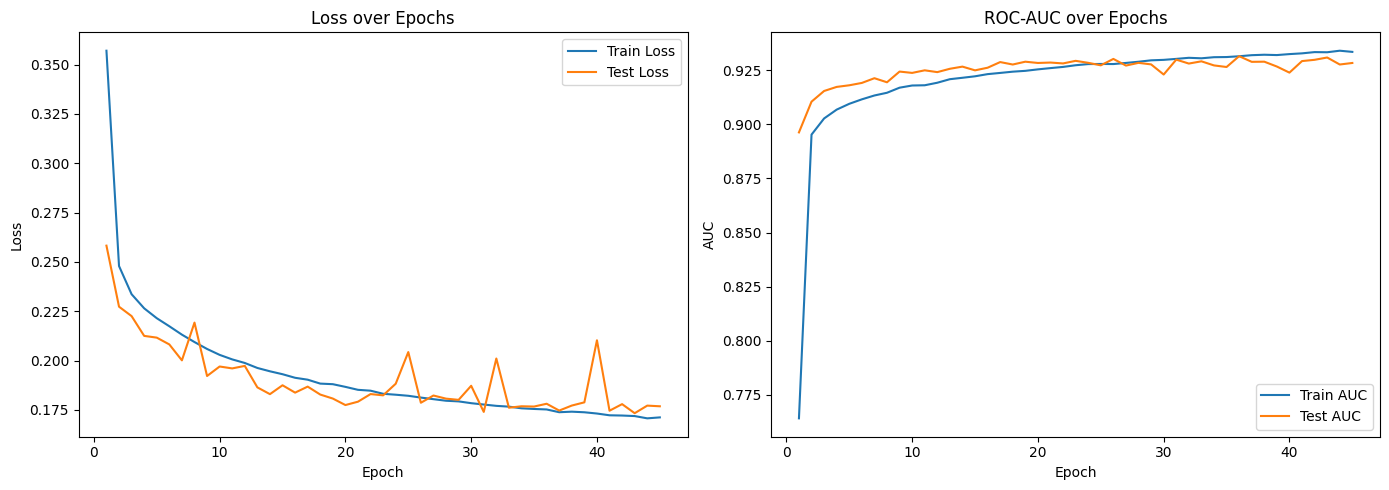

In [20]:
model = DeepMLP(input_dim=X_train_tensor.shape[1], hidden_size=128, num_blocks=3)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    epochs=45,
)

trainer.train()
trainer.plot_metrics('experiment_2')

In [26]:
experiment_2 = {
    'test_aucs': trainer.test_aucs,
    'train_aucs': trainer.train_aucs,
    'test_losses': trainer.test_losses,
    'train_losses': trainer.train_losses,
    'label': "exp2"
    }
save_experiment_to_csv(experiment_2, 'experiment_2.csv')
experiment_2

Эксперимент сохранён в experiment_2.csv


{'test_aucs': [np.float64(0.8963133772216997),
  np.float64(0.9105360650468447),
  np.float64(0.915476720515232),
  np.float64(0.9173612218902155),
  np.float64(0.9181090701301174),
  np.float64(0.919201438078118),
  np.float64(0.921386412066523),
  np.float64(0.9195031011535577),
  np.float64(0.9244554231497243),
  np.float64(0.9238399542862585),
  np.float64(0.9250347019678337),
  np.float64(0.924201616647421),
  np.float64(0.9257480268092046),
  np.float64(0.9267458720729514),
  np.float64(0.9250232735324582),
  np.float64(0.9262365924215188),
  np.float64(0.9288477518124785),
  np.float64(0.9277189557267176),
  np.float64(0.9290241782835917),
  np.float64(0.9284375186009691),
  np.float64(0.9286285877549078),
  np.float64(0.9282196640516184),
  np.float64(0.9294229830597255),
  np.float64(0.9285025178271687),
  np.float64(0.9273430078213354),
  np.float64(0.9303060677849074),
  np.float64(0.9272296758371925),
  np.float64(0.9284934703158295),
  np.float64(0.9277780026428255),
  np.

In [24]:
print(max( enumerate(experiment_2["test_aucs"]), key = lambda x: x[1] ))
print(min( enumerate(experiment_2["test_losses"]), key = lambda x: x[1] ))

(35, np.float64(0.9315812906989203))
(42, 0.1733111924222668)


✅ График сохранён как compare_1_to_2.png


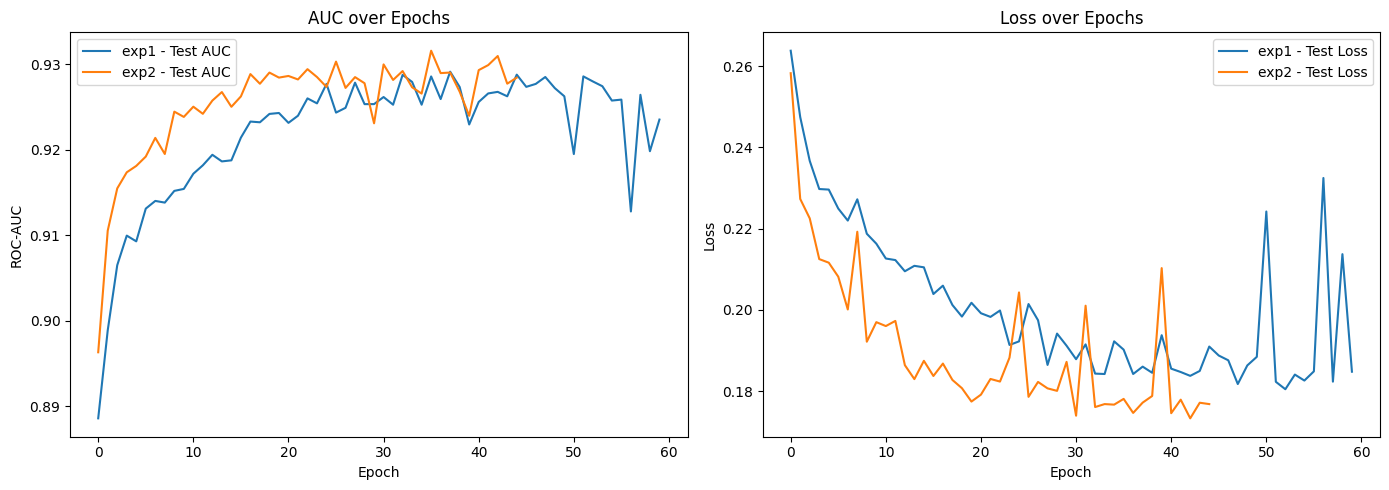

In [36]:
plot_all_experiments([experiment_1, experiment_2], 'test', 'compare_1_to_2')

Выводы:
По тестовым данным
* Минимальный loss: 0.1733
* Максимальный AUC: 0.9315

Здесь заметно, что переобучение происходит примерно на 25-й эпохе и новые минимумы по loss достигаются скорее засчёт случайности нежели из-за оптимального количества эпох. График test_loss и test_auc стал ещё более резким и угловатым, однако в любом случае есть значительное улучшение относительно прошлой модели.

## Эксперимент 3

In [37]:
# Блок с BatchNorm + Skip Connection
class SkipBlock(nn.Module):
    def __init__(self, hidden_size):
        super(SkipBlock, self).__init__()
        self.norm = nn.BatchNorm1d(hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x):
        residual = x  # skip
        out = self.norm(x)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        return out + residual  # добавляем skip connection

class SkipMLP(nn.Module):
    def __init__(self, input_dim, hidden_size=128, num_blocks=3):
        super(SkipMLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.blocks = nn.Sequential(
            *[SkipBlock(hidden_size) for _ in range(num_blocks)]
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

Epoch 1/45 | Train Loss: 0.2584, AUC: 0.8870 | Test Loss: 0.2314, AUC: 0.9113
Epoch 2/45 | Train Loss: 0.2378, AUC: 0.9012 | Test Loss: 0.2302, AUC: 0.9135
Epoch 3/45 | Train Loss: 0.2309, AUC: 0.9056 | Test Loss: 0.2160, AUC: 0.9166
Epoch 4/45 | Train Loss: 0.2243, AUC: 0.9095 | Test Loss: 0.2147, AUC: 0.9188
Epoch 5/45 | Train Loss: 0.2203, AUC: 0.9123 | Test Loss: 0.2213, AUC: 0.9219
Epoch 6/45 | Train Loss: 0.2164, AUC: 0.9130 | Test Loss: 0.2126, AUC: 0.9232
Epoch 7/45 | Train Loss: 0.2137, AUC: 0.9145 | Test Loss: 0.1987, AUC: 0.9231
Epoch 8/45 | Train Loss: 0.2102, AUC: 0.9167 | Test Loss: 0.2107, AUC: 0.9228
Epoch 9/45 | Train Loss: 0.2079, AUC: 0.9185 | Test Loss: 0.2064, AUC: 0.9225
Epoch 10/45 | Train Loss: 0.2064, AUC: 0.9189 | Test Loss: 0.2009, AUC: 0.9239
Epoch 11/45 | Train Loss: 0.2043, AUC: 0.9200 | Test Loss: 0.2016, AUC: 0.9252
Epoch 12/45 | Train Loss: 0.2025, AUC: 0.9206 | Test Loss: 0.1990, AUC: 0.9267
Epoch 13/45 | Train Loss: 0.2015, AUC: 0.9212 | Test Loss: 0.

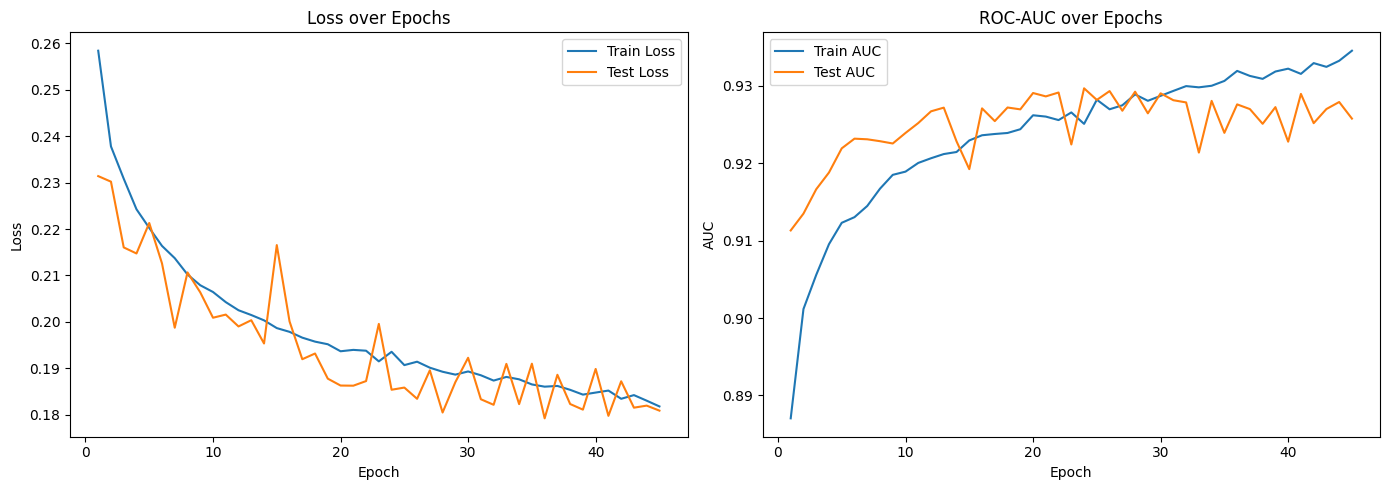

In [38]:
model = SkipMLP(input_dim=X_train_tensor.shape[1], hidden_size=128, num_blocks=3)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    epochs=45,
)

trainer.train()
trainer.plot_metrics(filename_prefix="experiment_3")

In [39]:
experiment_3 = {
    'test_aucs': trainer.test_aucs,
    'train_aucs': trainer.train_aucs,
    'test_losses': trainer.test_losses,
    'train_losses': trainer.train_losses,
    'label': "exp3"
    }
save_experiment_to_csv(experiment_3, 'experiment_3.csv')
experiment_3

Эксперимент сохранён в experiment_3.csv


{'test_aucs': [np.float64(0.911316055761241),
  np.float64(0.9134896013142701),
  np.float64(0.9166386114451017),
  np.float64(0.9188002523779479),
  np.float64(0.9219211676051475),
  np.float64(0.9231732955560055),
  np.float64(0.9230921060463566),
  np.float64(0.9228468708705848),
  np.float64(0.9225490172736039),
  np.float64(0.923912096284568),
  np.float64(0.9251913667694432),
  np.float64(0.9267056344567325),
  np.float64(0.9271818192640564),
  np.float64(0.9228309186795396),
  np.float64(0.9192357233842454),
  np.float64(0.9270868203949952),
  np.float64(0.9254427923477101),
  np.float64(0.9271999142867345),
  np.float64(0.9269589647742289),
  np.float64(0.9290710824871132),
  np.float64(0.9286344210187973),
  np.float64(0.9291367959905241),
  np.float64(0.9224224711610576),
  np.float64(0.9296786943012583),
  np.float64(0.9281784740657849),
  np.float64(0.9293198890489398),
  np.float64(0.9267839668575374),
  np.float64(0.9292422709253462),
  np.float64(0.9264463518291449),
  n

✅ График сохранён как compare_2_to_3.png


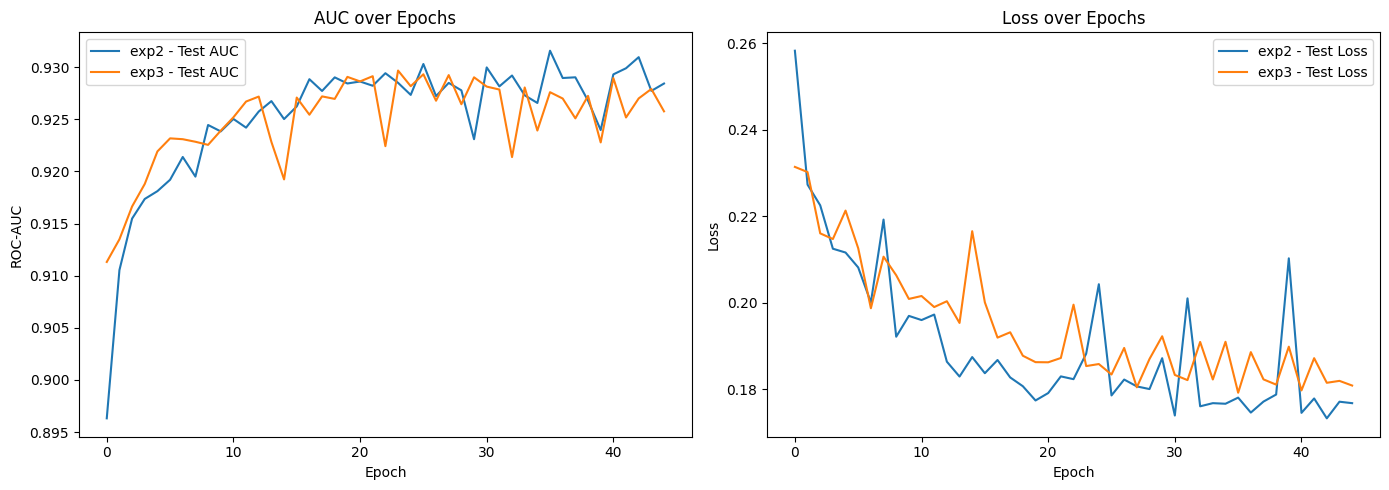

In [41]:
plot_all_experiments([experiment_2, experiment_3], 'test', 'compare_2_to_3')

In [40]:
print(max( enumerate(experiment_3["test_aucs"]), key = lambda x: x[1] ))
print(min( enumerate(experiment_3["test_losses"]), key = lambda x: x[1] ))

(23, np.float64(0.9296786943012583))
(35, 0.1792276117706136)


Выводы:

Skip Connections и Batch Norm не улучшили результат относительно 2 эксперимента. Вероятно это из-за того что такое усложнение модели делает её более чувствительной к batch_size и learning_rate, которые у нас могли быть выставлены не лучшим образом для такой модели.

Либо же ожидаемое улучшение результата могло бы сработать для модели с большим количеством слоёв. Точно сказать сложно.

* Минимальный loss: 0.1792
* Максимальный AUC: 0.9297


## Эксперимент 4

In [43]:
class DropoutBlock(nn.Module):
    def __init__(self, hidden_size, dropout_rate=0.1):
        super(DropoutBlock, self).__init__()
        self.norm = nn.BatchNorm1d(hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x):
        residual = x
        out = self.norm(x)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out + residual

class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_size=128, num_blocks=3, dropout_rate=0.1):
        super(DropoutMLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_size)
        self.blocks = nn.Sequential(
            *[DropoutBlock(hidden_size, dropout_rate) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x


Запуск модели с dropout = 0.01
Epoch 1/35 | Train Loss: 0.2618, AUC: 0.8837 | Test Loss: 0.2242, AUC: 0.9123
Epoch 2/35 | Train Loss: 0.2381, AUC: 0.9006 | Test Loss: 0.2279, AUC: 0.9171
Epoch 3/35 | Train Loss: 0.2309, AUC: 0.9053 | Test Loss: 0.2105, AUC: 0.9197
Epoch 4/35 | Train Loss: 0.2251, AUC: 0.9083 | Test Loss: 0.2047, AUC: 0.9221
Epoch 5/35 | Train Loss: 0.2216, AUC: 0.9101 | Test Loss: 0.2064, AUC: 0.9200
Epoch 6/35 | Train Loss: 0.2168, AUC: 0.9140 | Test Loss: 0.2089, AUC: 0.9209
Epoch 7/35 | Train Loss: 0.2147, AUC: 0.9153 | Test Loss: 0.2076, AUC: 0.9210
Epoch 8/35 | Train Loss: 0.2122, AUC: 0.9159 | Test Loss: 0.1957, AUC: 0.9244
Epoch 9/35 | Train Loss: 0.2109, AUC: 0.9165 | Test Loss: 0.1980, AUC: 0.9250
Epoch 10/35 | Train Loss: 0.2075, AUC: 0.9185 | Test Loss: 0.2121, AUC: 0.9208
Epoch 11/35 | Train Loss: 0.2074, AUC: 0.9181 | Test Loss: 0.1987, AUC: 0.9258
Epoch 12/35 | Train Loss: 0.2047, AUC: 0.9200 | Test Loss: 0.1946, AUC: 0.9271
Epoch 13/35 | Train Loss: 0.2

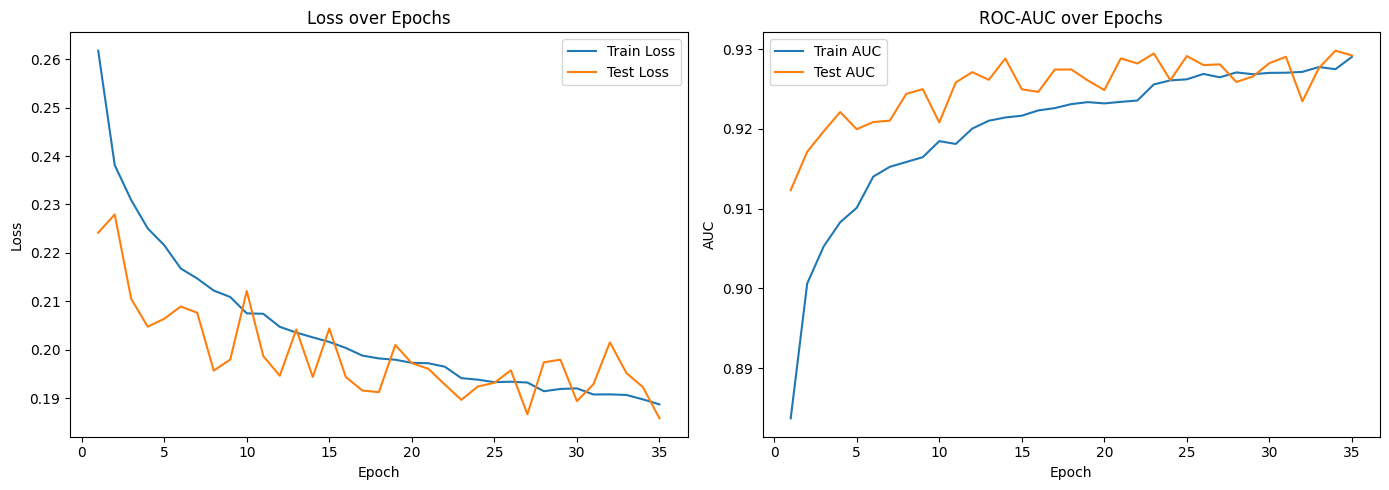

Эксперимент сохранён в experiment_4_dropout_0.01.csv

Запуск модели с dropout = 0.1
Epoch 1/35 | Train Loss: 0.2615, AUC: 0.8847 | Test Loss: 0.2271, AUC: 0.9115
Epoch 2/35 | Train Loss: 0.2423, AUC: 0.8984 | Test Loss: 0.2195, AUC: 0.9156
Epoch 3/35 | Train Loss: 0.2358, AUC: 0.9025 | Test Loss: 0.2163, AUC: 0.9169
Epoch 4/35 | Train Loss: 0.2317, AUC: 0.9049 | Test Loss: 0.2122, AUC: 0.9177
Epoch 5/35 | Train Loss: 0.2272, AUC: 0.9071 | Test Loss: 0.2124, AUC: 0.9187
Epoch 6/35 | Train Loss: 0.2250, AUC: 0.9081 | Test Loss: 0.2093, AUC: 0.9183
Epoch 7/35 | Train Loss: 0.2216, AUC: 0.9107 | Test Loss: 0.2039, AUC: 0.9222
Epoch 8/35 | Train Loss: 0.2197, AUC: 0.9103 | Test Loss: 0.2010, AUC: 0.9231
Epoch 9/35 | Train Loss: 0.2158, AUC: 0.9136 | Test Loss: 0.2069, AUC: 0.9214
Epoch 10/35 | Train Loss: 0.2157, AUC: 0.9131 | Test Loss: 0.2002, AUC: 0.9229
Epoch 11/35 | Train Loss: 0.2136, AUC: 0.9148 | Test Loss: 0.1988, AUC: 0.9217
Epoch 12/35 | Train Loss: 0.2113, AUC: 0.9160 | Test Los

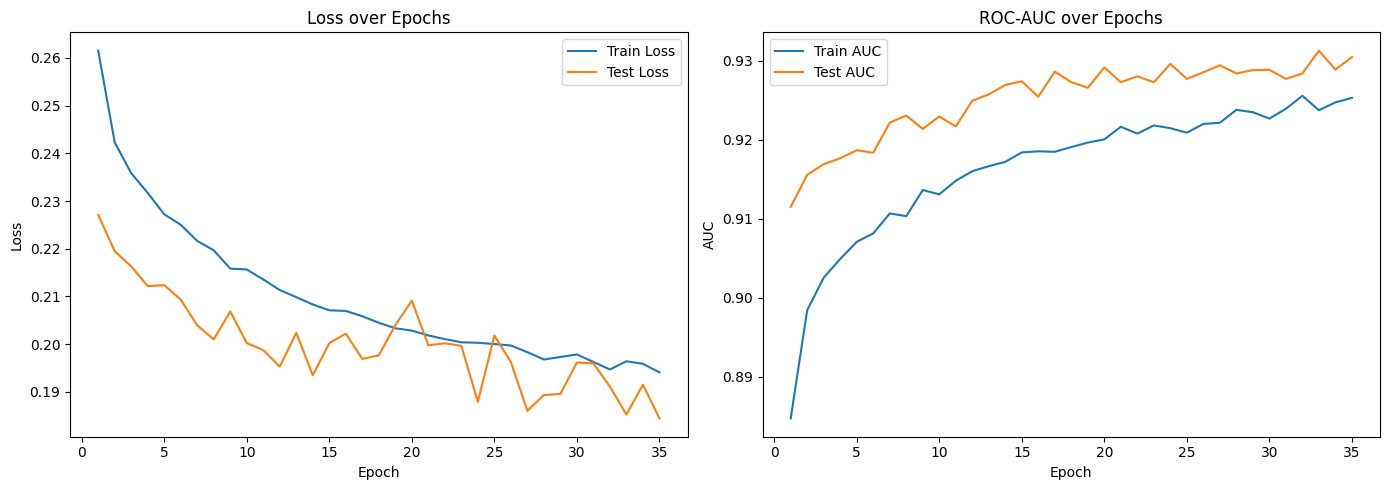

Эксперимент сохранён в experiment_4_dropout_0.1.csv

Запуск модели с dropout = 0.2
Epoch 1/35 | Train Loss: 0.2624, AUC: 0.8835 | Test Loss: 0.2345, AUC: 0.9106
Epoch 2/35 | Train Loss: 0.2426, AUC: 0.8982 | Test Loss: 0.2215, AUC: 0.9161
Epoch 3/35 | Train Loss: 0.2382, AUC: 0.9003 | Test Loss: 0.2207, AUC: 0.9168
Epoch 4/35 | Train Loss: 0.2332, AUC: 0.9035 | Test Loss: 0.2177, AUC: 0.9187
Epoch 5/35 | Train Loss: 0.2319, AUC: 0.9048 | Test Loss: 0.2112, AUC: 0.9188
Epoch 6/35 | Train Loss: 0.2278, AUC: 0.9069 | Test Loss: 0.2090, AUC: 0.9201
Epoch 7/35 | Train Loss: 0.2253, AUC: 0.9086 | Test Loss: 0.2173, AUC: 0.9215
Epoch 8/35 | Train Loss: 0.2237, AUC: 0.9088 | Test Loss: 0.2076, AUC: 0.9217
Epoch 9/35 | Train Loss: 0.2193, AUC: 0.9120 | Test Loss: 0.2042, AUC: 0.9228
Epoch 10/35 | Train Loss: 0.2191, AUC: 0.9109 | Test Loss: 0.1997, AUC: 0.9233
Epoch 11/35 | Train Loss: 0.2179, AUC: 0.9129 | Test Loss: 0.2079, AUC: 0.9240
Epoch 12/35 | Train Loss: 0.2158, AUC: 0.9140 | Test Loss

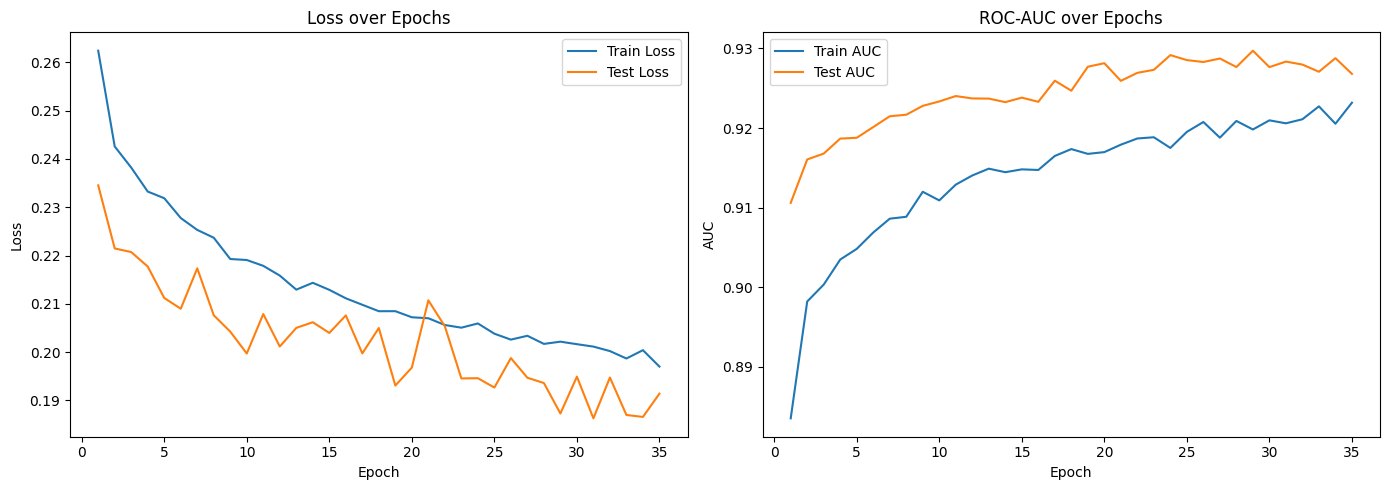

Эксперимент сохранён в experiment_4_dropout_0.2.csv

Запуск модели с dropout = 0.5
Epoch 1/35 | Train Loss: 0.2684, AUC: 0.8789 | Test Loss: 0.2296, AUC: 0.9110
Epoch 2/35 | Train Loss: 0.2512, AUC: 0.8935 | Test Loss: 0.2260, AUC: 0.9128
Epoch 3/35 | Train Loss: 0.2470, AUC: 0.8947 | Test Loss: 0.2254, AUC: 0.9150
Epoch 4/35 | Train Loss: 0.2439, AUC: 0.8971 | Test Loss: 0.2202, AUC: 0.9163
Epoch 5/35 | Train Loss: 0.2405, AUC: 0.8998 | Test Loss: 0.2210, AUC: 0.9145
Epoch 6/35 | Train Loss: 0.2383, AUC: 0.9004 | Test Loss: 0.2191, AUC: 0.9162
Epoch 7/35 | Train Loss: 0.2358, AUC: 0.9019 | Test Loss: 0.2210, AUC: 0.9170
Epoch 8/35 | Train Loss: 0.2347, AUC: 0.9025 | Test Loss: 0.2182, AUC: 0.9191
Epoch 9/35 | Train Loss: 0.2324, AUC: 0.9042 | Test Loss: 0.2218, AUC: 0.9165
Epoch 10/35 | Train Loss: 0.2321, AUC: 0.9042 | Test Loss: 0.2131, AUC: 0.9186
Epoch 11/35 | Train Loss: 0.2311, AUC: 0.9043 | Test Loss: 0.2127, AUC: 0.9200
Epoch 12/35 | Train Loss: 0.2288, AUC: 0.9061 | Test Loss

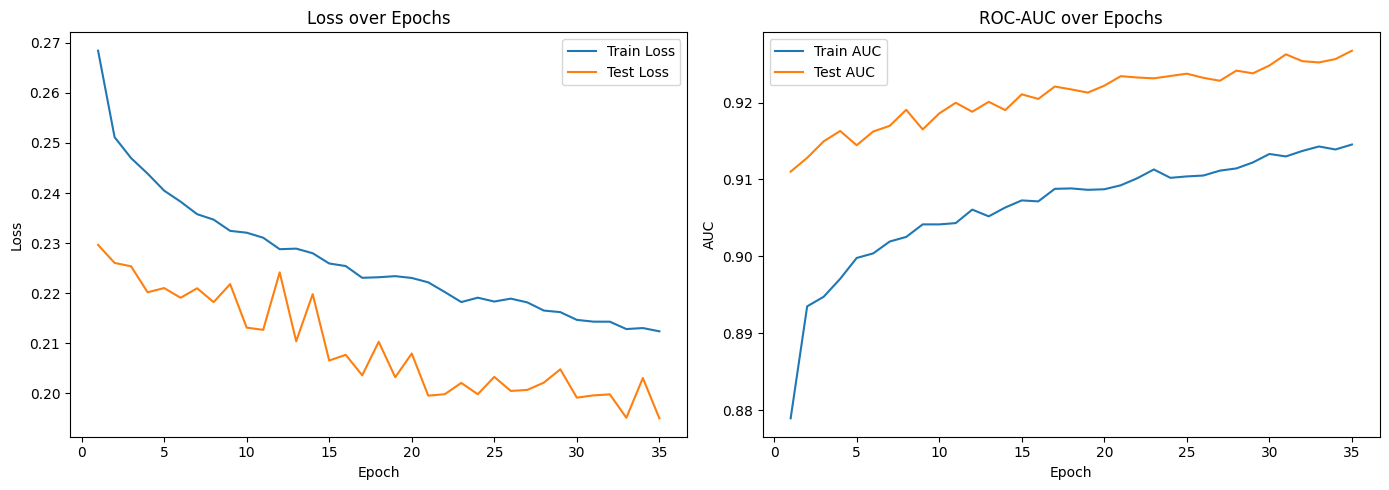

Эксперимент сохранён в experiment_4_dropout_0.5.csv

Запуск модели с dropout = 0.9
Epoch 1/35 | Train Loss: 0.3011, AUC: 0.8462 | Test Loss: 0.2532, AUC: 0.8942
Epoch 2/35 | Train Loss: 0.2789, AUC: 0.8699 | Test Loss: 0.2475, AUC: 0.9013
Epoch 3/35 | Train Loss: 0.2739, AUC: 0.8747 | Test Loss: 0.2419, AUC: 0.9036
Epoch 4/35 | Train Loss: 0.2688, AUC: 0.8785 | Test Loss: 0.2422, AUC: 0.9051
Epoch 5/35 | Train Loss: 0.2661, AUC: 0.8810 | Test Loss: 0.2384, AUC: 0.9078
Epoch 6/35 | Train Loss: 0.2642, AUC: 0.8829 | Test Loss: 0.2371, AUC: 0.9058
Epoch 7/35 | Train Loss: 0.2623, AUC: 0.8843 | Test Loss: 0.2380, AUC: 0.9078
Epoch 8/35 | Train Loss: 0.2611, AUC: 0.8851 | Test Loss: 0.2345, AUC: 0.9098
Epoch 9/35 | Train Loss: 0.2582, AUC: 0.8874 | Test Loss: 0.2329, AUC: 0.9096
Epoch 10/35 | Train Loss: 0.2590, AUC: 0.8865 | Test Loss: 0.2358, AUC: 0.9092
Epoch 11/35 | Train Loss: 0.2588, AUC: 0.8868 | Test Loss: 0.2326, AUC: 0.9091
Epoch 12/35 | Train Loss: 0.2568, AUC: 0.8877 | Test Loss

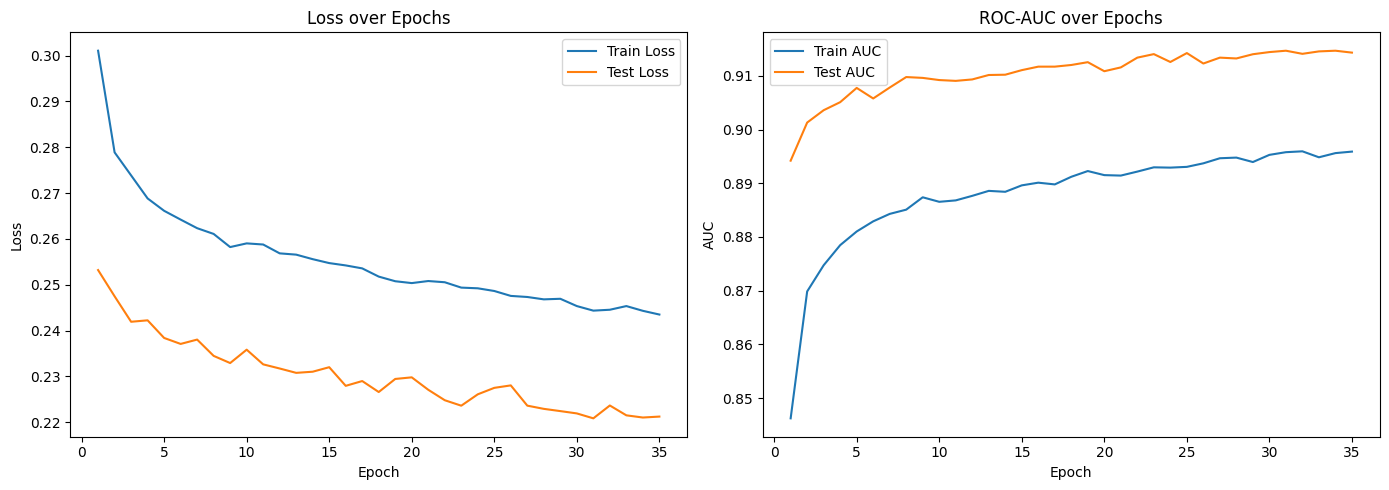

Эксперимент сохранён в experiment_4_dropout_0.9.csv


In [46]:
dropout_rates = [0.01, 0.1, 0.2, 0.5, 0.9]
experiment_results = []

for p in dropout_rates:
    print(f"\nЗапуск модели с dropout = {p}")

    model = DropoutMLP(input_dim=X_train_tensor.shape[1], dropout_rate=p)

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        learning_rate=0.01,
        weight_decay=0.0,
        epochs=35,
        device='cuda'
    )

    trainer.train()
    prefix = f"experiment_4_dropout_{p}"

    # Сохраняем график
    trainer.plot_metrics(filename_prefix=prefix)

    # Сохраняем CSV
    experiment_dict = {
        'label': f'dropout_{p}',
        'train_losses': trainer.train_losses,
        'test_losses': trainer.test_losses,
        'train_aucs': trainer.train_aucs,
        'test_aucs': trainer.test_aucs
    }
    save_experiment_to_csv(experiment_dict, f"{prefix}.csv")
    experiment_results.append(experiment_dict)

In [47]:
# Находим лучший по финальному test AUC
best = max(experiment_results, key=lambda x: x['test_aucs'][-1])
print(f"\nЛучший dropout_rate: {best['label']} — Test AUC: {best['test_aucs'][-1]:.4f}")


Лучший dropout_rate: dropout_0.1 — Test AUC: 0.9305


In [55]:
experiment_results

[{'label': 'dropout_0.01',
  'train_losses': [0.2617804250851776,
   0.2381459369052762,
   0.23089714796085076,
   0.22505070213009662,
   0.22158686158872998,
   0.2167681421055492,
   0.21469298148977345,
   0.21220192706417793,
   0.21087514194587542,
   0.20750157367600416,
   0.20740755918397286,
   0.20471236569388385,
   0.20352153684908625,
   0.20253756246407767,
   0.20158497324582528,
   0.20034410215634746,
   0.1987730865408047,
   0.1981818232969065,
   0.19790971782249048,
   0.1972732563109595,
   0.1971866787191411,
   0.1964682910434673,
   0.1941035046015964,
   0.19379215759732318,
   0.1932768939638192,
   0.1933693172670576,
   0.19320215430956258,
   0.19139972952176515,
   0.19187474696077872,
   0.19199254191161197,
   0.19073517518474462,
   0.19075408446468065,
   0.19062693341634815,
   0.18972166227702617,
   0.18868783118373383],
  'test_losses': [0.22416067016195865,
   0.22793795385120877,
   0.2104802070422144,
   0.2047444315822533,
   0.2063790343759

✅ График сохранён как compare_dropout.png


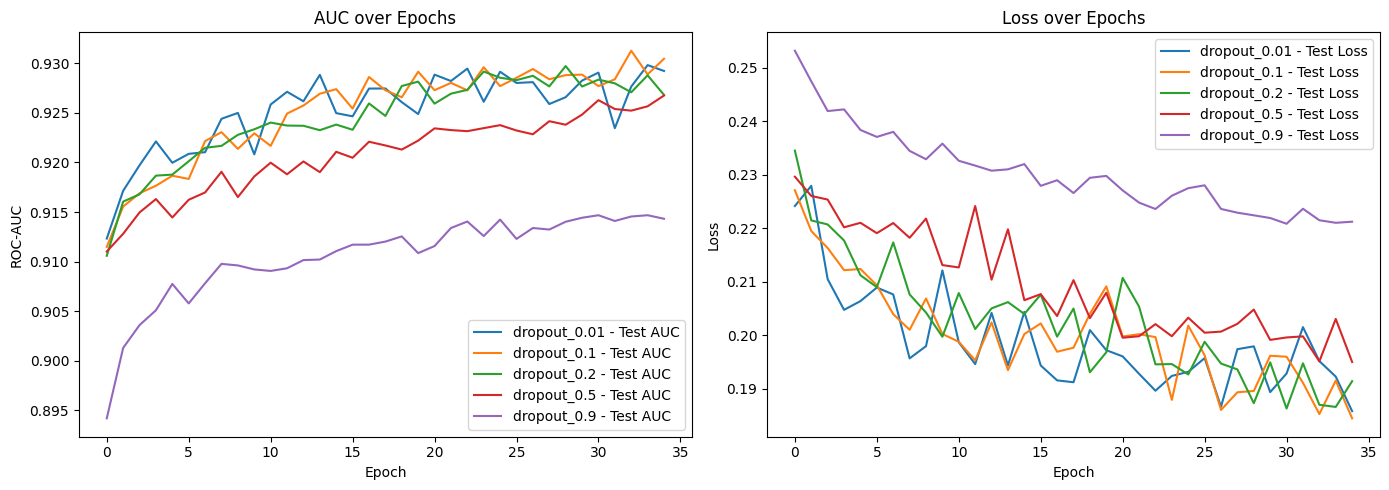

In [56]:
plot_all_experiments(experiment_results, 'test', 'compare_dropout')

Выводы:

Заметно улучшение относительно 3 эксперимента.
Наилучшая модель - dropout_rate = 0.1.

За 35 эпох переобучение можно заметить только при dropout_rate = 0.01,
что значит, что dropout в данном случае действительно помог улучшить модель обучения.

Тем не менее модель всё ещё немного отстаёт от 2-го эксперимента по качеству.

Вероятно это всё ещё из-за неправильного learning_rate.

* Минимальный loss: 0.1845
* Максимальный AUC: 0.9305

## Эксперимент 5

In [49]:
learning_rates = [0.01, 0.05, 0.1]
weight_decays = [0.1, 0.01, 0.001]
dropout_rate = 0.1  # фиксируем dropout


Обучаем модель: lr=0.01, weight_decay=0.1
Epoch 1/35 | Train Loss: 0.3037, AUC: 0.8602 | Test Loss: 0.3097, AUC: 0.8639
Epoch 2/35 | Train Loss: 0.3189, AUC: 0.8519 | Test Loss: 0.3138, AUC: 0.8613
Epoch 3/35 | Train Loss: 0.3188, AUC: 0.8525 | Test Loss: 0.3140, AUC: 0.8622
Epoch 4/35 | Train Loss: 0.3188, AUC: 0.8527 | Test Loss: 0.3138, AUC: 0.8632
Epoch 5/35 | Train Loss: 0.3185, AUC: 0.8530 | Test Loss: 0.3137, AUC: 0.8600
Epoch 6/35 | Train Loss: 0.3190, AUC: 0.8523 | Test Loss: 0.3137, AUC: 0.8646
Epoch 7/35 | Train Loss: 0.3187, AUC: 0.8534 | Test Loss: 0.3118, AUC: 0.8600
Epoch 8/35 | Train Loss: 0.3185, AUC: 0.8524 | Test Loss: 0.3156, AUC: 0.8667
Epoch 9/35 | Train Loss: 0.3186, AUC: 0.8532 | Test Loss: 0.3139, AUC: 0.8617
Epoch 10/35 | Train Loss: 0.3190, AUC: 0.8527 | Test Loss: 0.3126, AUC: 0.8614
Epoch 11/35 | Train Loss: 0.3186, AUC: 0.8526 | Test Loss: 0.3135, AUC: 0.8628
Epoch 12/35 | Train Loss: 0.3186, AUC: 0.8528 | Test Loss: 0.3129, AUC: 0.8592
Epoch 13/35 | Trai

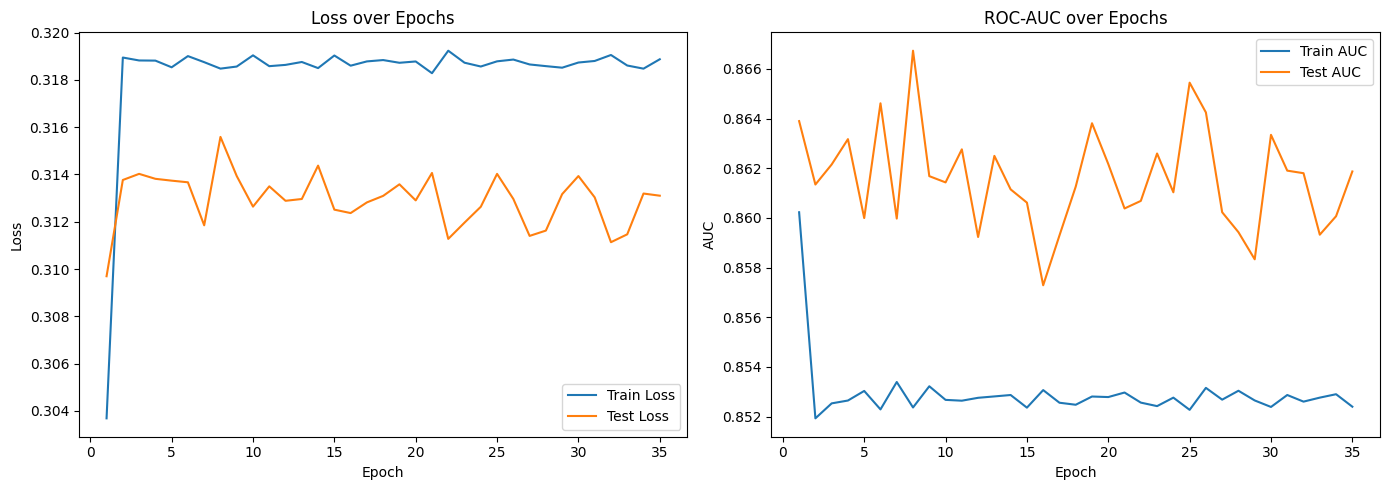

Эксперимент сохранён в experiment_5_lr_0.01_wd_0.1.csv

Обучаем модель: lr=0.01, weight_decay=0.01
Epoch 1/35 | Train Loss: 0.2631, AUC: 0.8838 | Test Loss: 0.2346, AUC: 0.9078
Epoch 2/35 | Train Loss: 0.2449, AUC: 0.8974 | Test Loss: 0.2271, AUC: 0.9134
Epoch 3/35 | Train Loss: 0.2414, AUC: 0.8995 | Test Loss: 0.2252, AUC: 0.9146
Epoch 4/35 | Train Loss: 0.2392, AUC: 0.9011 | Test Loss: 0.2205, AUC: 0.9173
Epoch 5/35 | Train Loss: 0.2384, AUC: 0.9011 | Test Loss: 0.2234, AUC: 0.9155
Epoch 6/35 | Train Loss: 0.2361, AUC: 0.9026 | Test Loss: 0.2198, AUC: 0.9176
Epoch 7/35 | Train Loss: 0.2368, AUC: 0.9017 | Test Loss: 0.2238, AUC: 0.9182
Epoch 8/35 | Train Loss: 0.2349, AUC: 0.9036 | Test Loss: 0.2183, AUC: 0.9176
Epoch 9/35 | Train Loss: 0.2347, AUC: 0.9037 | Test Loss: 0.2202, AUC: 0.9163
Epoch 10/35 | Train Loss: 0.2342, AUC: 0.9036 | Test Loss: 0.2163, AUC: 0.9193
Epoch 11/35 | Train Loss: 0.2335, AUC: 0.9040 | Test Loss: 0.2185, AUC: 0.9176
Epoch 12/35 | Train Loss: 0.2341, AUC: 0.

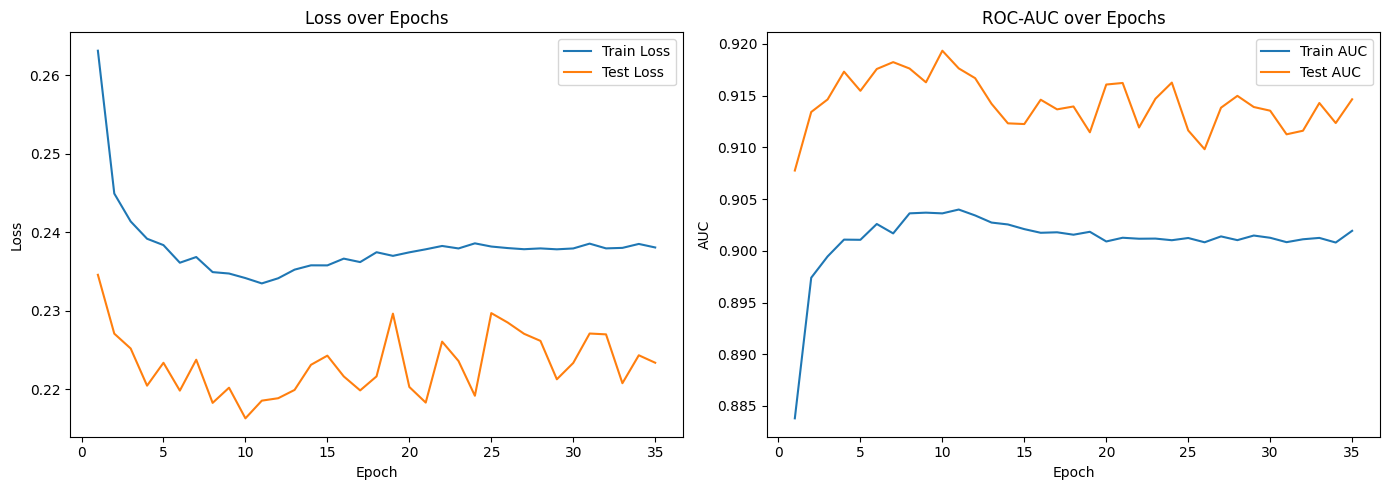

Эксперимент сохранён в experiment_5_lr_0.01_wd_0.01.csv

Обучаем модель: lr=0.01, weight_decay=0.001
Epoch 1/35 | Train Loss: 0.2625, AUC: 0.8835 | Test Loss: 0.2269, AUC: 0.9129
Epoch 2/35 | Train Loss: 0.2430, AUC: 0.8983 | Test Loss: 0.2230, AUC: 0.9163
Epoch 3/35 | Train Loss: 0.2359, AUC: 0.9023 | Test Loss: 0.2224, AUC: 0.9149
Epoch 4/35 | Train Loss: 0.2320, AUC: 0.9045 | Test Loss: 0.2147, AUC: 0.9199
Epoch 5/35 | Train Loss: 0.2277, AUC: 0.9076 | Test Loss: 0.2076, AUC: 0.9206
Epoch 6/35 | Train Loss: 0.2246, AUC: 0.9078 | Test Loss: 0.2084, AUC: 0.9203
Epoch 7/35 | Train Loss: 0.2222, AUC: 0.9099 | Test Loss: 0.2120, AUC: 0.9211
Epoch 8/35 | Train Loss: 0.2200, AUC: 0.9110 | Test Loss: 0.2060, AUC: 0.9223
Epoch 9/35 | Train Loss: 0.2180, AUC: 0.9136 | Test Loss: 0.2087, AUC: 0.9227
Epoch 10/35 | Train Loss: 0.2162, AUC: 0.9135 | Test Loss: 0.2075, AUC: 0.9214
Epoch 11/35 | Train Loss: 0.2156, AUC: 0.9140 | Test Loss: 0.2095, AUC: 0.9217
Epoch 12/35 | Train Loss: 0.2144, AUC: 

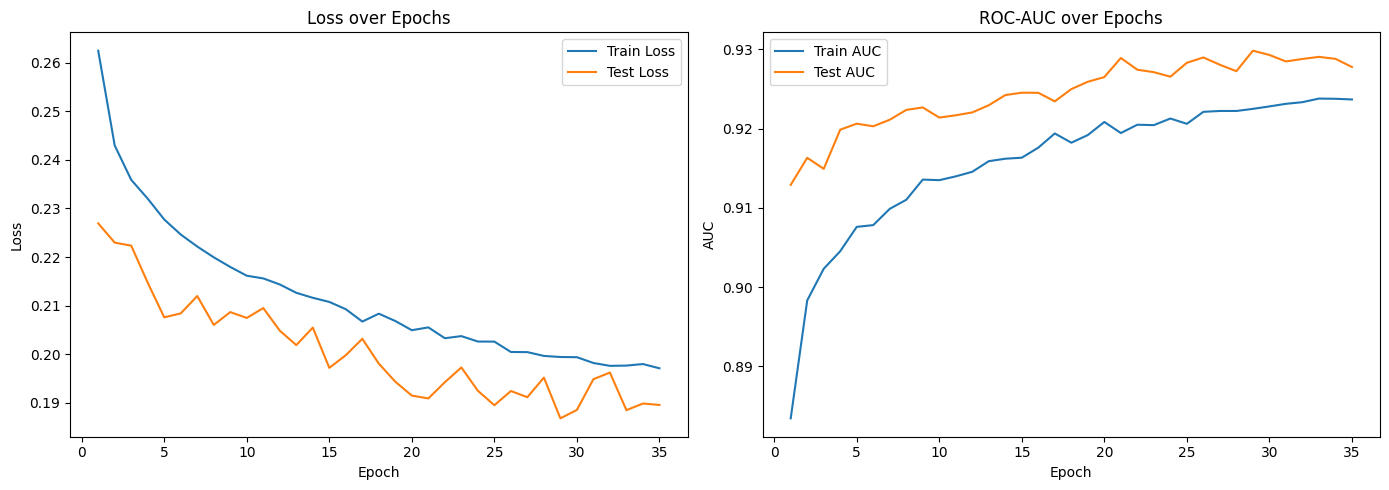

Эксперимент сохранён в experiment_5_lr_0.01_wd_0.001.csv

Обучаем модель: lr=0.05, weight_decay=0.1
Epoch 1/35 | Train Loss: 0.3175, AUC: 0.8498 | Test Loss: 0.3158, AUC: 0.8676
Epoch 2/35 | Train Loss: 0.3196, AUC: 0.8503 | Test Loss: 0.3189, AUC: 0.8591
Epoch 3/35 | Train Loss: 0.3201, AUC: 0.8493 | Test Loss: 0.3113, AUC: 0.8633
Epoch 4/35 | Train Loss: 0.3195, AUC: 0.8500 | Test Loss: 0.3160, AUC: 0.8546
Epoch 5/35 | Train Loss: 0.3201, AUC: 0.8497 | Test Loss: 0.3117, AUC: 0.8637
Epoch 6/35 | Train Loss: 0.3197, AUC: 0.8497 | Test Loss: 0.3135, AUC: 0.8662
Epoch 7/35 | Train Loss: 0.3197, AUC: 0.8501 | Test Loss: 0.3151, AUC: 0.8507
Epoch 8/35 | Train Loss: 0.3196, AUC: 0.8501 | Test Loss: 0.3188, AUC: 0.8616
Epoch 9/35 | Train Loss: 0.3201, AUC: 0.8491 | Test Loss: 0.3137, AUC: 0.8540
Epoch 10/35 | Train Loss: 0.3199, AUC: 0.8498 | Test Loss: 0.3116, AUC: 0.8571
Epoch 11/35 | Train Loss: 0.3198, AUC: 0.8497 | Test Loss: 0.3147, AUC: 0.8671
Epoch 12/35 | Train Loss: 0.3198, AUC: 0

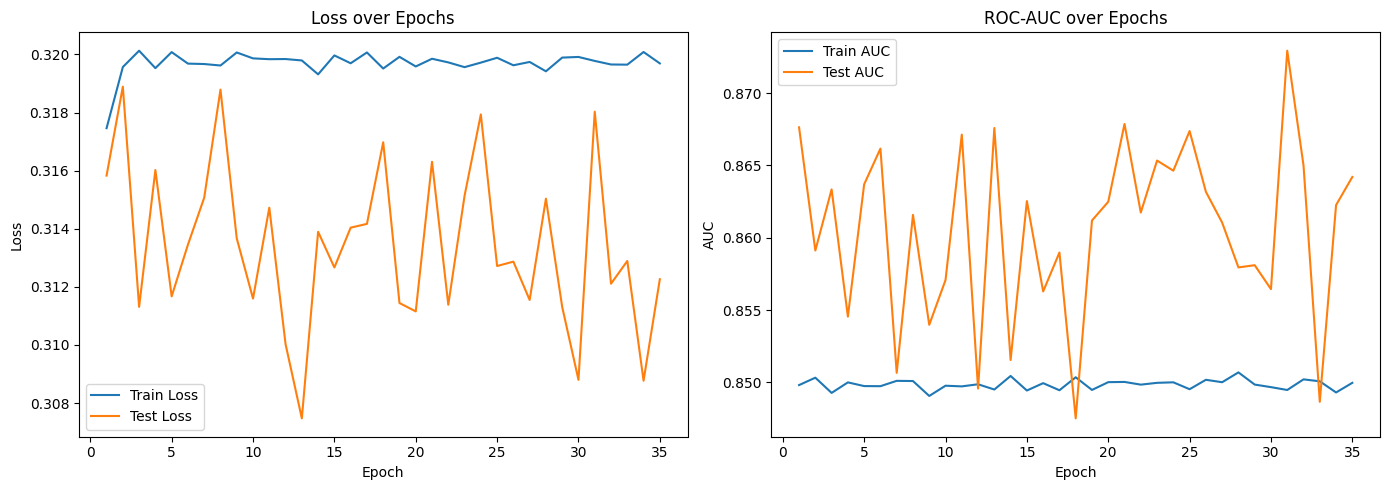

Эксперимент сохранён в experiment_5_lr_0.05_wd_0.1.csv

Обучаем модель: lr=0.05, weight_decay=0.01
Epoch 1/35 | Train Loss: 0.2547, AUC: 0.8900 | Test Loss: 0.2280, AUC: 0.9120
Epoch 2/35 | Train Loss: 0.2463, AUC: 0.8966 | Test Loss: 0.2305, AUC: 0.9121
Epoch 3/35 | Train Loss: 0.2490, AUC: 0.8943 | Test Loss: 0.2405, AUC: 0.9008
Epoch 4/35 | Train Loss: 0.2511, AUC: 0.8933 | Test Loss: 0.2355, AUC: 0.9088
Epoch 5/35 | Train Loss: 0.2529, AUC: 0.8927 | Test Loss: 0.2662, AUC: 0.8853
Epoch 6/35 | Train Loss: 0.2532, AUC: 0.8924 | Test Loss: 0.2463, AUC: 0.9043
Epoch 7/35 | Train Loss: 0.2534, AUC: 0.8925 | Test Loss: 0.2438, AUC: 0.9032
Epoch 8/35 | Train Loss: 0.2536, AUC: 0.8919 | Test Loss: 0.2442, AUC: 0.9003
Epoch 9/35 | Train Loss: 0.2540, AUC: 0.8913 | Test Loss: 0.2542, AUC: 0.8953
Epoch 10/35 | Train Loss: 0.2534, AUC: 0.8920 | Test Loss: 0.2452, AUC: 0.9057
Epoch 11/35 | Train Loss: 0.2526, AUC: 0.8925 | Test Loss: 0.2406, AUC: 0.9048
Epoch 12/35 | Train Loss: 0.2529, AUC: 0.

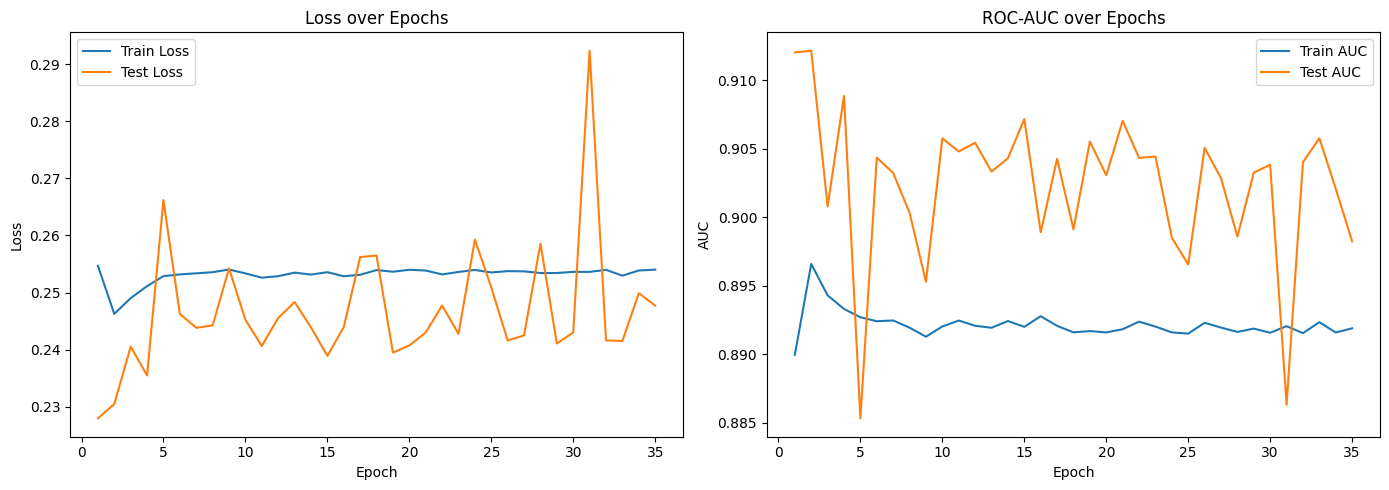

Эксперимент сохранён в experiment_5_lr_0.05_wd_0.01.csv

Обучаем модель: lr=0.05, weight_decay=0.001
Epoch 1/35 | Train Loss: 0.2525, AUC: 0.8911 | Test Loss: 0.2275, AUC: 0.9117
Epoch 2/35 | Train Loss: 0.2342, AUC: 0.9018 | Test Loss: 0.2092, AUC: 0.9194
Epoch 3/35 | Train Loss: 0.2249, AUC: 0.9072 | Test Loss: 0.1977, AUC: 0.9237
Epoch 4/35 | Train Loss: 0.2208, AUC: 0.9104 | Test Loss: 0.2092, AUC: 0.9208
Epoch 5/35 | Train Loss: 0.2164, AUC: 0.9126 | Test Loss: 0.2165, AUC: 0.9185
Epoch 6/35 | Train Loss: 0.2137, AUC: 0.9141 | Test Loss: 0.2017, AUC: 0.9255
Epoch 7/35 | Train Loss: 0.2124, AUC: 0.9153 | Test Loss: 0.1973, AUC: 0.9253
Epoch 8/35 | Train Loss: 0.2107, AUC: 0.9157 | Test Loss: 0.1909, AUC: 0.9279
Epoch 9/35 | Train Loss: 0.2083, AUC: 0.9176 | Test Loss: 0.1931, AUC: 0.9257
Epoch 10/35 | Train Loss: 0.2080, AUC: 0.9173 | Test Loss: 0.2031, AUC: 0.9221
Epoch 11/35 | Train Loss: 0.2081, AUC: 0.9172 | Test Loss: 0.1943, AUC: 0.9265
Epoch 12/35 | Train Loss: 0.2082, AUC: 

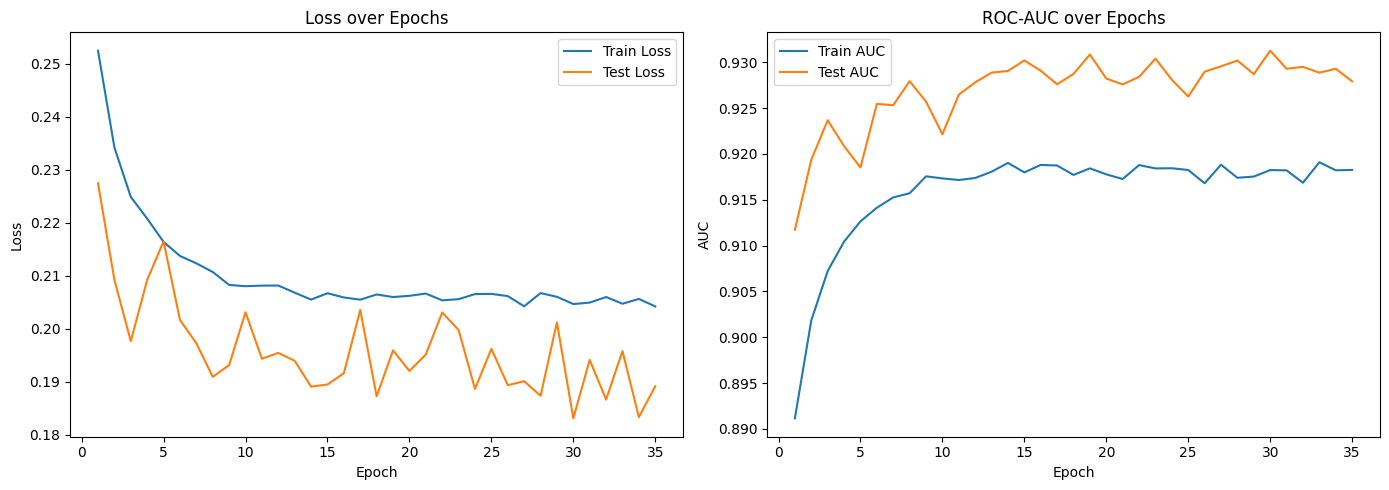

Эксперимент сохранён в experiment_5_lr_0.05_wd_0.001.csv

Обучаем модель: lr=0.1, weight_decay=0.1
Epoch 1/35 | Train Loss: 0.3204, AUC: 0.8451 | Test Loss: 0.3142, AUC: 0.8673
Epoch 2/35 | Train Loss: 0.3212, AUC: 0.8466 | Test Loss: 0.3103, AUC: 0.8589
Epoch 3/35 | Train Loss: 0.3211, AUC: 0.8463 | Test Loss: 0.3139, AUC: 0.8489
Epoch 4/35 | Train Loss: 0.3211, AUC: 0.8459 | Test Loss: 0.3171, AUC: 0.8557
Epoch 5/35 | Train Loss: 0.3215, AUC: 0.8454 | Test Loss: 0.3144, AUC: 0.8564
Epoch 6/35 | Train Loss: 0.3211, AUC: 0.8461 | Test Loss: 0.3152, AUC: 0.8552
Epoch 7/35 | Train Loss: 0.3215, AUC: 0.8457 | Test Loss: 0.3160, AUC: 0.8515
Epoch 8/35 | Train Loss: 0.3212, AUC: 0.8464 | Test Loss: 0.3164, AUC: 0.8437
Epoch 9/35 | Train Loss: 0.3210, AUC: 0.8463 | Test Loss: 0.3204, AUC: 0.8504
Epoch 10/35 | Train Loss: 0.3213, AUC: 0.8464 | Test Loss: 0.3152, AUC: 0.8566
Epoch 11/35 | Train Loss: 0.3214, AUC: 0.8465 | Test Loss: 0.3085, AUC: 0.8589
Epoch 12/35 | Train Loss: 0.3212, AUC: 0.

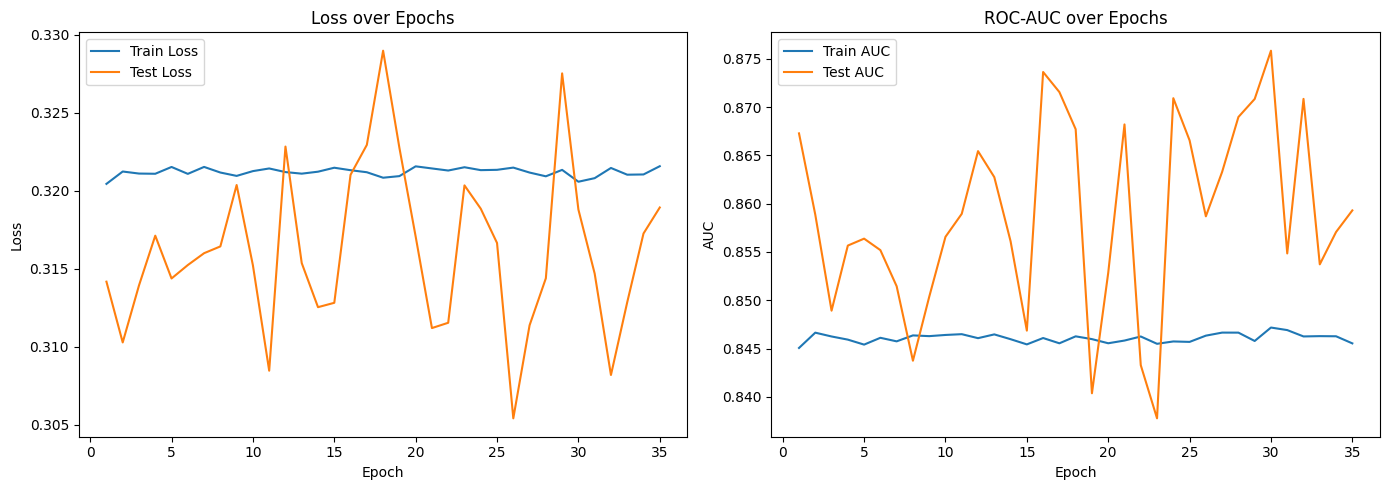

Эксперимент сохранён в experiment_5_lr_0.1_wd_0.1.csv

Обучаем модель: lr=0.1, weight_decay=0.01
Epoch 1/35 | Train Loss: 0.2575, AUC: 0.8866 | Test Loss: 0.2340, AUC: 0.9080
Epoch 2/35 | Train Loss: 0.2550, AUC: 0.8901 | Test Loss: 0.2382, AUC: 0.9045
Epoch 3/35 | Train Loss: 0.2574, AUC: 0.8897 | Test Loss: 0.2521, AUC: 0.8973
Epoch 4/35 | Train Loss: 0.2583, AUC: 0.8887 | Test Loss: 0.2505, AUC: 0.9020
Epoch 5/35 | Train Loss: 0.2587, AUC: 0.8885 | Test Loss: 0.2471, AUC: 0.9048
Epoch 6/35 | Train Loss: 0.2593, AUC: 0.8877 | Test Loss: 0.2458, AUC: 0.9068
Epoch 7/35 | Train Loss: 0.2588, AUC: 0.8878 | Test Loss: 0.2490, AUC: 0.9040
Epoch 8/35 | Train Loss: 0.2592, AUC: 0.8877 | Test Loss: 0.2615, AUC: 0.8954
Epoch 9/35 | Train Loss: 0.2585, AUC: 0.8889 | Test Loss: 0.2425, AUC: 0.9045
Epoch 10/35 | Train Loss: 0.2591, AUC: 0.8876 | Test Loss: 0.2439, AUC: 0.9014
Epoch 11/35 | Train Loss: 0.2587, AUC: 0.8883 | Test Loss: 0.2432, AUC: 0.9032
Epoch 12/35 | Train Loss: 0.2589, AUC: 0.88

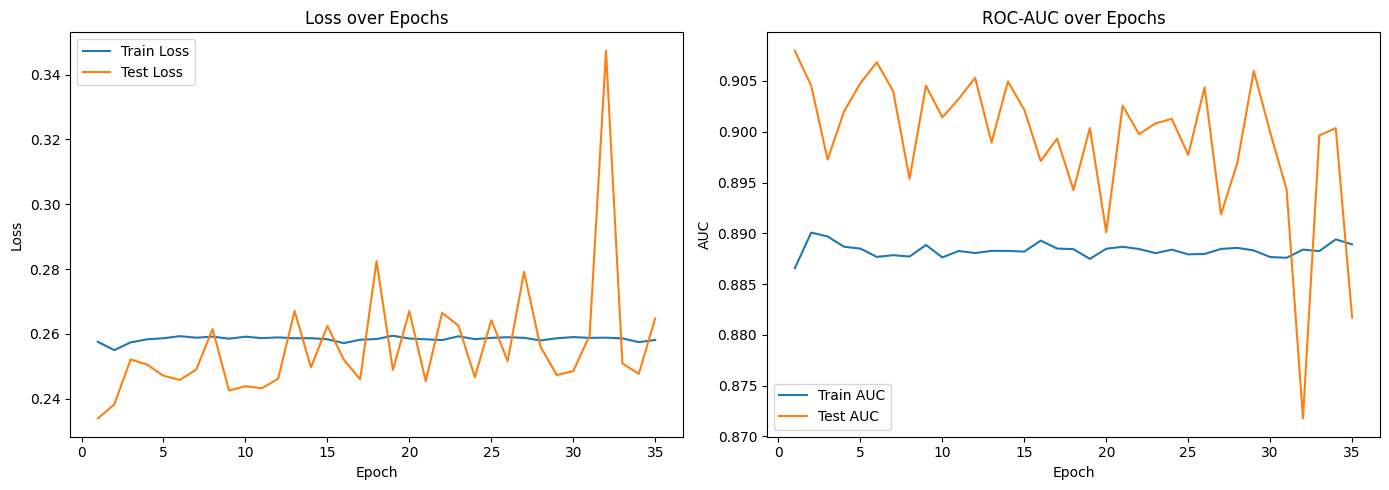

Эксперимент сохранён в experiment_5_lr_0.1_wd_0.01.csv

Обучаем модель: lr=0.1, weight_decay=0.001
Epoch 1/35 | Train Loss: 0.2527, AUC: 0.8892 | Test Loss: 0.2196, AUC: 0.9177
Epoch 2/35 | Train Loss: 0.2320, AUC: 0.9032 | Test Loss: 0.2126, AUC: 0.9184
Epoch 3/35 | Train Loss: 0.2248, AUC: 0.9076 | Test Loss: 0.2029, AUC: 0.9208
Epoch 4/35 | Train Loss: 0.2220, AUC: 0.9093 | Test Loss: 0.2146, AUC: 0.9203
Epoch 5/35 | Train Loss: 0.2199, AUC: 0.9107 | Test Loss: 0.2044, AUC: 0.9261
Epoch 6/35 | Train Loss: 0.2171, AUC: 0.9126 | Test Loss: 0.2001, AUC: 0.9259
Epoch 7/35 | Train Loss: 0.2176, AUC: 0.9123 | Test Loss: 0.2135, AUC: 0.9228
Epoch 8/35 | Train Loss: 0.2175, AUC: 0.9118 | Test Loss: 0.1994, AUC: 0.9260
Epoch 9/35 | Train Loss: 0.2166, AUC: 0.9124 | Test Loss: 0.2040, AUC: 0.9242
Epoch 10/35 | Train Loss: 0.2163, AUC: 0.9129 | Test Loss: 0.1977, AUC: 0.9283
Epoch 11/35 | Train Loss: 0.2155, AUC: 0.9133 | Test Loss: 0.2191, AUC: 0.9227
Epoch 12/35 | Train Loss: 0.2152, AUC: 0.

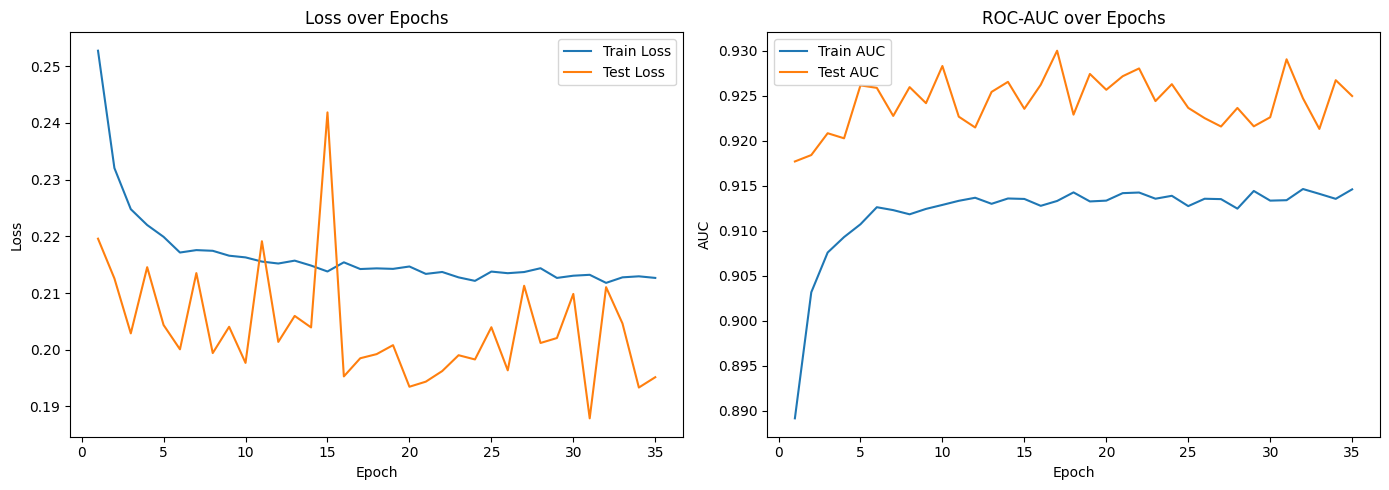

Эксперимент сохранён в experiment_5_lr_0.1_wd_0.001.csv


In [52]:
experiment_5_results = []

for lr in learning_rates:
    for wd in weight_decays:
        print(f"\nОбучаем модель: lr={lr}, weight_decay={wd}")

        model = DropoutMLP(input_dim=X_train_tensor.shape[1], dropout_rate=dropout_rate)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            learning_rate=lr,
            weight_decay=wd,
            epochs=35,
        )

        trainer.train()
        prefix = f"experiment_5_lr_{lr}_wd_{wd}"

        # Сохраняем график
        trainer.plot_metrics(filename_prefix=prefix)

        # Сохраняем метрики
        experiment_dict = {
            'label': f'lr={lr}_wd={wd}',
            'train_losses': trainer.train_losses,
            'test_losses': trainer.test_losses,
            'train_aucs': trainer.train_aucs,
            'test_aucs': trainer.test_aucs
        }
        save_experiment_to_csv(experiment_dict, f"{prefix}.csv")
        experiment_5_results.append(experiment_dict)


In [53]:
best_exp = max(experiment_5_results, key=lambda x: x['test_aucs'][-1])
print(f"\nЛучшая комбинация: {best_exp['label']} — Test AUC: {best_exp['test_aucs'][-1]:.4f}")


Лучшая комбинация: lr=0.05_wd=0.001 — Test AUC: 0.9279


Epoch 1/45 | Train Loss: 0.2529, AUC: 0.8905 | Test Loss: 0.2263, AUC: 0.9128
Epoch 2/45 | Train Loss: 0.2339, AUC: 0.9021 | Test Loss: 0.2073, AUC: 0.9217
Epoch 3/45 | Train Loss: 0.2259, AUC: 0.9065 | Test Loss: 0.2109, AUC: 0.9179
Epoch 4/45 | Train Loss: 0.2209, AUC: 0.9099 | Test Loss: 0.2102, AUC: 0.9250
Epoch 5/45 | Train Loss: 0.2181, AUC: 0.9116 | Test Loss: 0.1947, AUC: 0.9269
Epoch 6/45 | Train Loss: 0.2146, AUC: 0.9136 | Test Loss: 0.2016, AUC: 0.9266
Epoch 7/45 | Train Loss: 0.2128, AUC: 0.9155 | Test Loss: 0.1926, AUC: 0.9274
Epoch 8/45 | Train Loss: 0.2107, AUC: 0.9158 | Test Loss: 0.1989, AUC: 0.9251
Epoch 9/45 | Train Loss: 0.2100, AUC: 0.9168 | Test Loss: 0.2102, AUC: 0.9266
Epoch 10/45 | Train Loss: 0.2099, AUC: 0.9162 | Test Loss: 0.1951, AUC: 0.9267
Epoch 11/45 | Train Loss: 0.2083, AUC: 0.9168 | Test Loss: 0.1953, AUC: 0.9274
Epoch 12/45 | Train Loss: 0.2077, AUC: 0.9185 | Test Loss: 0.1922, AUC: 0.9288
Epoch 13/45 | Train Loss: 0.2068, AUC: 0.9176 | Test Loss: 0.

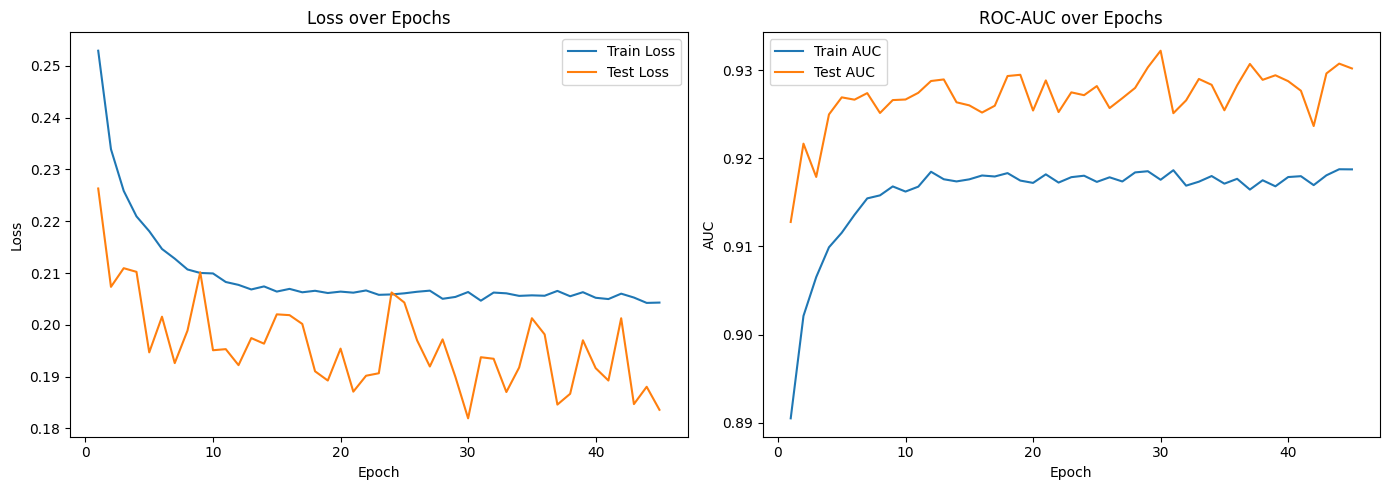

✅ График сохранён как compare_5_to_2.png


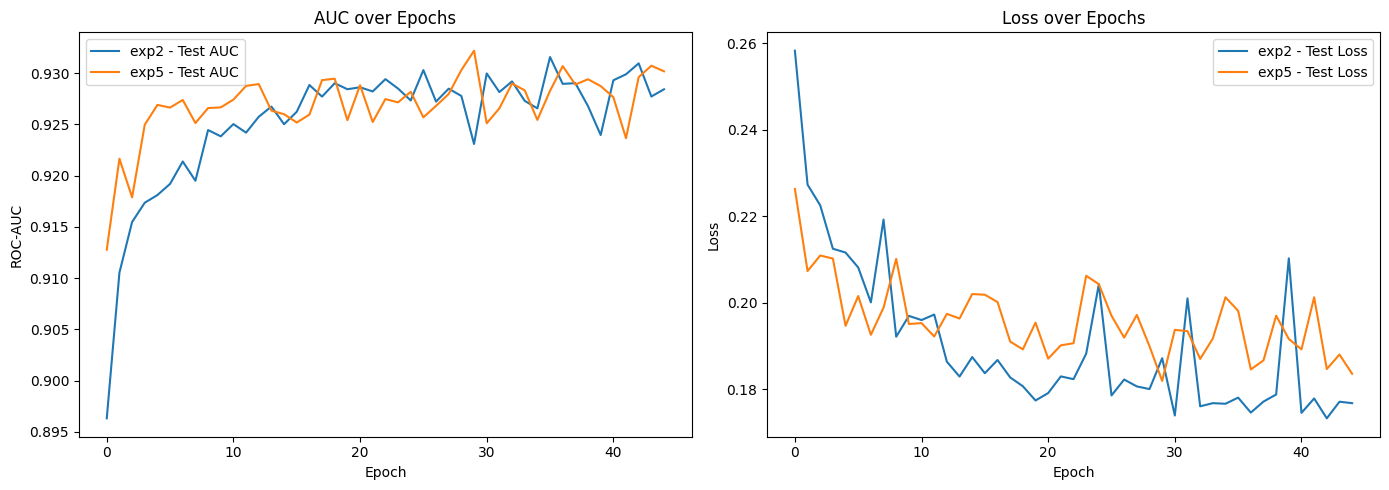

In [57]:
model = DropoutMLP(input_dim=X_train_tensor.shape[1], dropout_rate=dropout_rate)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.05,
    weight_decay=0.001,
    epochs=45,
)

trainer.train()
prefix = f"experiment_5_best"

# Сохраняем график
trainer.plot_metrics(filename_prefix=prefix)

plot_all_experiments([experiment_2,
                      {
            'label': f'exp5',
            'train_losses': trainer.train_losses,
            'test_losses': trainer.test_losses,
            'train_aucs': trainer.train_aucs,
            'test_aucs': trainer.test_aucs
        }
                      ], 'test', 'compare_5_to_2')

In [58]:
print(max( enumerate(trainer.test_aucs), key = lambda x: x[1] ))
print(min( enumerate(trainer.test_losses), key = lambda x: x[1] ))

(29, np.float64(0.9321974738395973))
(29, 0.18195893120176246)


Выводы:

Большой weight_decay для нашей задачи не подходит.

Аналогично, learning_rate=0.1 слишком велик и график test_loss сильно колеблется.

Возможно такая модель обогнала бы 2-й эксперимент очень сильно, если бы мы поставили большое количество эпох, но есть ощущение, что это было бы скорее по случайности, чем из-за реально оптимальной модели обучения.

Возможно стоило бы перебрать другие значения learning_rate или каким-то образом доработать модель, но пока что выглядит так, что мы лишь переусложняем задачу, которая неплохо решалась и на 2-м эксперименте.

Налучшая модель: lr=0.05_wd=0.001

* Test AUC: 0.9321
* Test Loss: 0.1820

Технически, по ROC-AUC она действительно обогнала 2-ю модель, так что можно считать эту модель улучшением.
